In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# For preprocessing
from sklearn.preprocessing import StandardScaler, LabelEncoder,  OneHotEncoder
from sklearn_pandas import DataFrameMapper

import torch # For building the networks 
import torchtuples as tt # Some useful functions

from pycox.datasets import metabric
from pycox.models import LogisticHazard
# from pycox.models import PMF
# from pycox.models import DeepHitSingle
from pycox.evaluation import EvalSurv

In [4]:
# We also set some seeds to make this reproducable.
# Note that on gpu, there is still some randomness.
np.random.seed(1234)
_ = torch.manual_seed(123)

In [28]:
# Dataset

path = "E:/Research/Ovarian Cancer/Articles/Orginal/"
data = pd.read_excel(path+"data_ready.xlsx")

df_train = data
df_test = df_train.sample(frac=0.2)
df_train = df_train.drop(df_test.index)
df_val = df_train.sample(frac=0.2)
df_train = df_train.drop(df_val.index)

In [29]:
df_train.head()

,Age,Grading,Histology,Type,Status,MonthSurvive,YearSurvive
0,33.0,2.0,Undifferentiated,type_2,1.0,0,1
3,68.0,9.0,Non-specific,Non-specific,1.0,0,1
7,61.0,9.0,Serous carcinoma,type_2,1.0,2,1
8,72.0,9.0,Non-specific,Non-specific,1.0,1,1
10,88.0,9.0,Sex cord-stromal,Sex cord-stromal,1.0,1,1


In [31]:
# Feature transformers

cols_standardize = ['Age']
cols_labelencoded = ['Grading', 'Histology', 'Type']

standardize = [([col], StandardScaler()) for col in cols_standardize]
#onehot_encoded = [([col], OneHotEncoder(handle_unknown='ignore')) for col in cols_onehotencoded]

encoded = [([col], LabelEncoder()) for col in cols_labelencoded]
#leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + encoded)

In [32]:
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n

In [33]:
# label transforms

num_durations = 10

labtrans = LogisticHazard.label_transform(num_durations)
# labtrans = PMF.label_transform(num_durations)
# labtrans = DeepHitSingle.label_transform(num_durations)

get_target = lambda df: (df['YearSurvive'].values, df['Status'].values)
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))

train = (x_train, y_train)
val = (x_val, y_val)

# We don't need to transform the test labels
durations_test, events_test = get_target(df_test)

In [34]:
type(labtrans)

pycox.preprocessing.label_transforms.LabTransDiscreteTime

In [35]:
# Neural Net

in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = labtrans.out_features
batch_norm = True
dropout = 0.1

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

In [36]:
# modeling

model = LogisticHazard(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts)
# model = PMF(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts)
# model = DeepHitSingle(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts)

In [37]:
batch_size = 256
epochs = 100
callbacks = [tt.cb.EarlyStopping()]

In [38]:
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, val_data=val)

0:	[0s / 0s],		train_loss: 3.7163,	val_loss: 3.2217
1:	[0s / 0s],		train_loss: 3.1943,	val_loss: 2.3654
2:	[0s / 0s],		train_loss: 2.5879,	val_loss: 1.9400
3:	[0s / 0s],		train_loss: 1.9792,	val_loss: 1.6967
4:	[0s / 0s],		train_loss: 1.6558,	val_loss: 1.6657
5:	[0s / 0s],		train_loss: 1.5605,	val_loss: 1.6896
6:	[0s / 0s],		train_loss: 1.5195,	val_loss: 1.6418
7:	[0s / 0s],		train_loss: 1.5100,	val_loss: 1.6044
8:	[0s / 0s],		train_loss: 1.5006,	val_loss: 1.6005
9:	[0s / 0s],		train_loss: 1.4886,	val_loss: 1.6072
10:	[0s / 0s],		train_loss: 1.4796,	val_loss: 1.6027
11:	[0s / 0s],		train_loss: 1.4863,	val_loss: 1.6107
12:	[0s / 0s],		train_loss: 1.4874,	val_loss: 1.6100
13:	[0s / 0s],		train_loss: 1.4826,	val_loss: 1.6107
14:	[0s / 0s],		train_loss: 1.4774,	val_loss: 1.6099
15:	[0s / 0s],		train_loss: 1.4914,	val_loss: 1.6097
16:	[0s / 0s],		train_loss: 1.4676,	val_loss: 1.6047
17:	[0s / 0s],		train_loss: 1.4681,	val_loss: 1.6120
18:	[0s / 0s],		train_loss: 1.4695,	val_loss: 1.6177


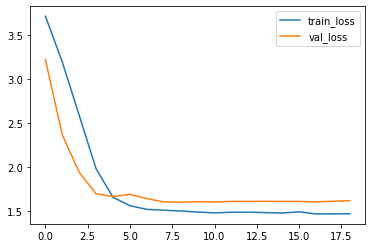

In [39]:
_ = log.plot()

In [40]:
log.to_pandas().val_loss.min()

1.6005080938339233

In [41]:
model.score_in_batches(val)

{'loss': 1.6005080938339233}

In [42]:
# prediction

surv = model.predict_surv_df(x_test)

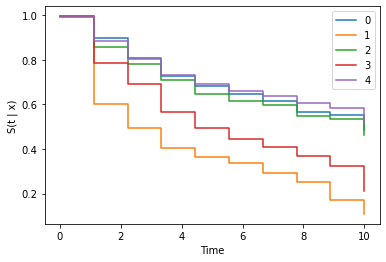

In [43]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [44]:
surv = model.interpolate(10).predict_surv_df(x_test)

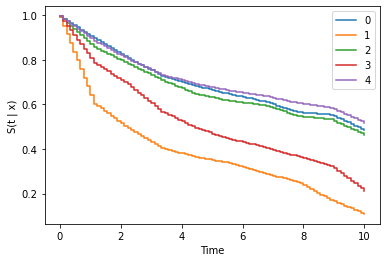

In [45]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [46]:
# evaluation

ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

In [47]:
ev.concordance_td('antolini')

0.6710589338306481

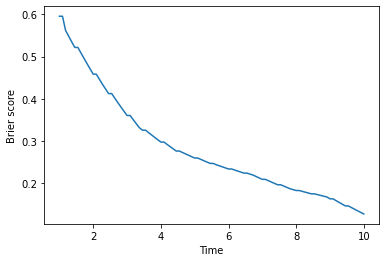

In [48]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
ev.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

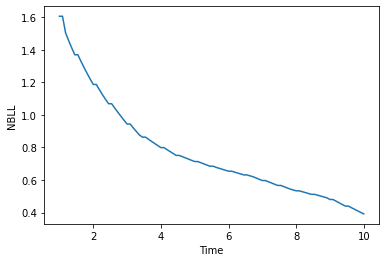

In [49]:
ev.nbll(time_grid).plot()
plt.ylabel('NBLL')
_ = plt.xlabel('Time')

In [50]:
ev.integrated_brier_score(time_grid) 

0.2807973423297068

In [51]:
ev.integrated_nbll(time_grid) 

0.7681375617440639